<a href="https://colab.research.google.com/github/kmcnamara1/cn/blob/main/ecg_af_classification_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
from google.colab import drive
drive.mount('/content/gdrive')
! pip install pyEDFlib

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
     |████████████████████████████████| 1.1MB 6.0MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for pyEDFlib: filename=pyEDFlib-0.1.18-cp36-cp36m-linux_x86_64.whl size=920482 sha256=a3fd48018f95fc2d7ed7f59e25ad4b85b1fc452432b3454b924e00a0b5a55def
  Stored in directory: /root/.cache/pip/wheels/4c/16/32/829749d6ab56f64e81e44aed0b4b9a892c975512c15cc3edbb
Successfully built pyEDFlib


In [2]:
cd gdrive/My Drive/CardioNexus/ecgAI

/content/gdrive/My Drive/CardioNexus/ecgAI


Conv-Net from Alerte Digital Health

In [15]:
import sys
from easydict import EasyDict as edict
import json, os, sys, time
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import *
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import *

from scipy.interpolate import interp1d
import pyedflib

from keras.callbacks import ModelCheckpoint, EarlyStopping

Load data

In [5]:
def load_data(config, study_num):
    lead = 0
    directory = './data/'
    goodDict = {}
    for filename in os.listdir(directory):
        if "Class" in filename: #sort class labels
            classList = np.loadtxt(directory + filename)
            if not 7 in classList:
                if not 6 in classList:
                    name = filename.split("_Class")[0].split("_0_")[0]
                    goodDict[name] = ''
    dict = {}
    dict2 = {}
    for filename in os.listdir(directory):
        name = filename.split("_Class")[0].split("_0_")[0]
        if name in goodDict.keys():
            if name in dict.keys():
                if 'image' in filename: #store data in dict[0]
                    dict[name][0] = np.loadtxt(directory + filename)
                elif 'Class' in filename:
                    dict[name][1] = np.loadtxt(directory + filename)
            else:
                dict[name] = [-1,-1]
                if 'image' in filename:
                    dict[name][0] = np.loadtxt(directory + filename)
                elif 'Class' in filename:
                    dict[name][1] = np.loadtxt(directory + filename)
        

    images = []
    labels = []
    numClass = config.label_dim
    filenames = []
    for key in dict.keys():
        if 're'in key:
          if type(dict[key][0]) != int and type(dict[key][1]) != int:
              images.append(dict[key][0][11])
              label = np.zeros((2000, numClass))
              temp_label = dict[key][1].copy()
              filenames.append(key)
              for i in range(2000):
                  label[i,int(temp_label[lead,i])] = 1 #reads temp label index 0 (lead 1)
              labels.append(label) 
        if '9ef71'in key:
          if type(dict[key][0]) != int and type(dict[key][1]) != int:
              images.append(dict[key][0][0])
              label = np.zeros((2000, numClass))
              temp_label = dict[key][1].copy()
              filenames.append(key)
              for i in range(2000):
                  label[i,int(temp_label[lead,i])] = 1 #reads temp label index 0 (lead 1)
              labels.append(label) 
            
    
    train_lst = np.load('/content/gdrive/My Drive/CardioNexus/ecgAI/cvData/' + config.data + '/splits/train_lst_' + str(study_num) + '.npy')
    val_lst = np.load('/content/gdrive/My Drive/CardioNexus/ecgAI/cvData/' + config.data + '/splits/val_lst_' + str(study_num) + '.npy')
    train_lst = train_lst.astype('U13')
    val_lst = val_lst.astype('U13')
    x_train = []
    y_train = []
    x_test = []
    y_test = []
    for i in range(len(filenames)):
        filename = filenames[i]
        study = filename
        # if study in train_lst:
        #     x_train.append(images[i])
        #     y_train.append(labels[i])
        if filename not in ['9ef71d292e7a5ea8b3395f74f6a4052ad9319be1b268c05bbc5732ef5c53', 's0117lre', 's0056lre']:
            x_train.append(images[i])
            y_train.append(labels[i])
        else:
            x_test.append(images[i])
            y_test.append(labels[i])
                    
    # x_train = np.array(x_train).reshape((-1,12,2000,1))
    # x_test = np.array(x_test).reshape((-1,12,2000,1))
    # y_train = np.array(y_train).reshape((-1,1,2000,6))
    # y_test = np.array(y_test).reshape((-1,1,2000,6))
    x_train = np.array(x_train).reshape((-1,1,2000,1))
    x_test = np.array(x_test).reshape((-1,1,2000,1))
    y_train = np.array(y_train).reshape((-1,1,2000,6))
    y_test = np.array(y_test).reshape((-1,1,2000,6))
    return x_train, x_test, y_train, y_test

In [6]:
with open('config.json', 'r+') as f:
    config = edict(json.load(f))
    
x_train, x_test, y_train, y_test = load_data(config, '0')

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(155, 1, 2000, 1) (3, 1, 2000, 1) (155, 1, 2000, 6) (3, 1, 2000, 6)


ECGAI Architecture

In [ ]:
# define cnn model - Alerte Architecture
def define_model():
  #Conv Block 1, 
  inputs = keras.Input(shape=(2500, 1, 1))
  conv_1 = layers.Conv2D(32, (625, 1), activation='relu', kernel_initializer='he_uniform', padding='same') (inputs)
  pool_1 = layers.MaxPooling2D((4, 1)) (conv_1)

  conv_2 = layers.Conv2D(32, (157, 1), activation='relu', kernel_initializer='he_uniform', padding='same') (pool_1)
  pool_2 = layers.MaxPooling2D((4, 1)) (conv_2)

  conv_3 = layers.Conv2D(32, (39, 1), activation='relu', kernel_initializer='he_uniform', padding='same') (pool_2)
  pool_3 = layers.MaxPooling2D((4, 1)) (conv_3)

  conv_4 = layers.Conv2D(32, (10, 1), activation='relu', kernel_initializer='he_uniform', padding='same') (pool_3)
  pool_4 = layers.MaxPooling2D((4, 1)) (conv_4)

  flat_1 = layers.Flatten() (pool_4)
  fc_1 = layers.Dense(2048, activation='softmax', kernel_initializer='he_uniform') (flat_1)
  fc_2 = layers.Dense(2048, activation='softmax', kernel_initializer='he_uniform') (fc_1)

  outputs = layers.Dense(3, activation='sigmoid') (fc_2)

  model = keras.Model(inputs=inputs, outputs=outputs, name="ecg_alerte")
  # compile model
  model.compile(optimizer='adam',loss='mean_squared_error', metrics=['accuracy'])
  return model

In [ ]:
# define cnn model - ECGAI Architecture keras.Input(shape=(12,2000,1))
def define_model():
  ## Conv Block 1, output: 2000x12x64
  inputs  = keras.Input(shape=(1,2000,1))
  conv_1_1 = layers.Conv2D(64, (19, 1), activation='relu', kernel_initializer='he_uniform', padding='same') (inputs)
  pool_1 = layers.MaxPooling2D((1, 2)) (conv_1_1)
 
  # ## Conv Block 2, output: 2000x12x128
  conv_2_1 = layers.Conv2D(128, (19, 1), activation='relu', kernel_initializer='he_uniform', padding='same') (pool_1)
  pool_2 = layers.MaxPooling2D((1, 2)) (conv_2_1)

  # ## Conv Block 3, output: 2000x12x256
  conv_3_1 = layers.Conv2D(256, (19, 1), activation='relu', kernel_initializer='he_uniform', padding='same') (pool_2)
  pool_3 = layers.MaxPooling2D((1, 2)) (conv_3_1)

  # ## Conv Block 4, output: 2000x12x512
  conv_4_1 = layers.Conv2D(512, (15, 1), activation='relu', kernel_initializer='he_uniform', padding='same') (pool_3)
  pool_4 = layers.MaxPooling2D((1, 2)) (conv_4_1)
  
  ## Conv Block 5, output: 2000x12x1024
  conv_5_1 = layers.Conv2D(1024, (15, 1), activation='relu', kernel_initializer='he_uniform', padding='same') (pool_4)
  deconv_5 = layers.Conv2DTranspose(512, (8,1), strides=(1,8), activation='relu', kernel_initializer='he_uniform', padding='same') (conv_5_1)
  pool_5 = layers.Concatenate(axis=3)([deconv_5, conv_2_1])
  
  ## Conv Block 6, output: 2000x12x512
  conv_6_1 = layers.Conv2D(512, (15, 1), activation='relu', kernel_initializer='he_uniform', padding='same') (pool_5)

  deconv_6 = layers.Conv2DTranspose(256, (2,1), strides=(1,2), activation='relu', kernel_initializer='he_uniform', padding='same') (conv_6_1)
  pool_6 = layers.Concatenate(axis=3)([deconv_6, conv_1_1]) 
  
  ## Conv Block 7, output: 2000x12x256
  conv_7_1 = layers.Conv2D(256, (11,1), activation='relu', kernel_initializer='he_uniform', padding='same') (pool_6)  
  #valid padding conv layer
  conv_8_0 = layers.Conv2D(512, (1,1), activation='relu', kernel_initializer='he_uniform', padding='valid') (conv_7_1)

  ## Conv Block 8, output: 2000x12x512
  conv_8_1 = layers.Conv2D(512, (11,1), activation='relu', kernel_initializer='he_uniform', padding='same') (conv_8_0)
  pool_8 = layers.MaxPooling2D((1,2)) (conv_8_1)

  ## Conv Block 9, output: 2000x12x1024
  conv_9_1 = layers.Conv2D(1024, (11,1), activation='relu', kernel_initializer='he_uniform', padding='same') (pool_8)
  deconv_9 = layers.Conv2DTranspose(512, (2,1), strides=(1,2), activation='relu', kernel_initializer='he_uniform', padding='same') (conv_9_1)
  pool_9 = layers.Concatenate(axis=3)([deconv_9, conv_8_1])
  ## Conv Block 10, output: 2000x12x512
  conv_10_1 = layers.Conv2D(512, (9, 1), activation='relu', kernel_initializer='he_uniform', padding='same') (pool_9)
  conv_10_2 = layers.Dropout(0.5) (conv_10_1)
  conv_10_3 = layers.Conv2D(512, (9, 1), activation='relu', kernel_initializer='he_uniform', padding='same') (conv_10_2)
  conv_10_4 = layers.Dropout(0.5) (conv_10_3)
  
  ## Conv Block 11, output: 2000x1x6
  conv_11 = layers.Conv1D(6, 1) (conv_10_4)
  outputs = conv_11

  model = keras.Model(inputs=inputs, outputs=outputs, name="ecg")
  # compile model
  model.compile(optimizer='adam',loss='mean_squared_error', metrics=['accuracy'])

  return model
  

In [ ]:
# define cnn model - ECGAI Architecture keras.Input(shape=(12,2000,1))
def define_model():
  ## Conv Block 1, output: 2000x12x64
  inputs  = keras.Input(shape=(1,2000,1))
  conv_1_1 = layers.Conv2D(64, (19, 1), activation='relu', kernel_initializer='he_uniform', padding='same') (inputs)
  conv_1_2 = layers.Conv2D(64, (19, 1), activation='relu', kernel_initializer='he_uniform', padding='same') (conv_1_1)
  conv_1_3 = layers.Conv2D(64, (19, 1), activation='relu', kernel_initializer='he_uniform', padding='same') (conv_1_2)

  pool_1 = layers.MaxPooling2D((1, 2)) (conv_1_3)

  # ## Conv Block 2, output: 2000x12x128
  conv_2_1 = layers.Conv2D(128, (19, 1), activation='relu', kernel_initializer='he_uniform', padding='same') (pool_1)
  conv_2_2 = layers.Conv2D(128, (19, 1), activation='relu', kernel_initializer='he_uniform', padding='same') (conv_2_1)
  conv_2_3 = layers.Conv2D(128, (19, 1), activation='relu', kernel_initializer='he_uniform', padding='same') (conv_2_2)
  
  pool_2 = layers.MaxPooling2D((1, 2)) (conv_2_3)

  # ## Conv Block 3, output: 2000x12x256
  conv_3_1 = layers.Conv2D(256, (19, 1), activation='relu', kernel_initializer='he_uniform', padding='same') (pool_2)
  conv_3_2 = layers.Conv2D(256, (19, 1), activation='relu', kernel_initializer='he_uniform', padding='same') (conv_3_1)
  conv_3_3 = layers.Conv2D(256, (19, 1), activation='relu', kernel_initializer='he_uniform', padding='same') (conv_3_2)

  pool_3 = layers.MaxPooling2D((1, 2)) (conv_3_3)

  # ## Conv Block 4, output: 2000x12x512
  conv_4_1 = layers.Conv2D(512, (15, 1), activation='relu', kernel_initializer='he_uniform', padding='same') (pool_3)
  conv_4_2 = layers.Conv2D(512, (15, 1), activation='relu', kernel_initializer='he_uniform', padding='same') (conv_4_1)
  conv_4_3 = layers.Conv2D(512, (15, 1), activation='relu', kernel_initializer='he_uniform', padding='same') (conv_4_2)

  pool_4 = layers.MaxPooling2D((1, 2)) (conv_4_3)

  ## Conv Block 5, output: 2000x12x1024
  conv_5_1 = layers.Conv2D(1024, (15, 1), activation='relu', kernel_initializer='he_uniform', padding='same') (pool_4)
  conv_5_2 = layers.Conv2D(1024, (15, 1), activation='relu', kernel_initializer='he_uniform', padding='same') (conv_5_1)
  conv_5_3 = layers.Conv2D(1024, (15, 1), activation='relu', kernel_initializer='he_uniform', padding='same') (conv_5_2)

  deconv_5 = layers.Conv2DTranspose(512, (8,1), strides=(1,8), activation='relu', kernel_initializer='he_uniform', padding='same') (conv_5_3)
  pool_5 = layers.Concatenate(axis=3)([deconv_5, conv_2_3])

  ## Conv Block 6, output: 2000x12x512
  conv_6_1 = layers.Conv2D(512, (15, 1), activation='relu', kernel_initializer='he_uniform', padding='same') (pool_5)
  conv_6_2 = layers.Conv2D(512, (15, 1), activation='relu', kernel_initializer='he_uniform', padding='same') (conv_6_1)
  conv_6_3 = layers.Conv2D(512, (15, 1), activation='relu', kernel_initializer='he_uniform', padding='same') (conv_6_2)

  deconv_6 = layers.Conv2DTranspose(256, (2,1), strides=(1,2), activation='relu', kernel_initializer='he_uniform', padding='same') (conv_6_3)
  pool_6 = layers.Concatenate(axis=3)([deconv_6, conv_1_3]) 

  ## Conv Block 7, output: 2000x12x256
  conv_7_1 = layers.Conv2D(256, (11,1), activation='relu', kernel_initializer='he_uniform', padding='same') (pool_6)
  conv_7_2 = layers.Conv2D(256, (11,1), activation='relu', kernel_initializer='he_uniform', padding='same') (conv_7_1)
  conv_7_3 = layers.Conv2D(256, (11,1), activation='relu', kernel_initializer='he_uniform', padding='same') (conv_7_2)

  #valid padding conv layer
  conv_8_0 = layers.Conv2D(512, (1,1), activation='relu', kernel_initializer='he_uniform', padding='valid') (conv_7_3)
  
  ## Conv Block 8, output: 2000x12x512
  conv_8_1 = layers.Conv2D(512, (11,1), activation='relu', kernel_initializer='he_uniform', padding='same') (conv_8_0)
  conv_8_2 = layers.Conv2D(512, (11,1), activation='relu', kernel_initializer='he_uniform', padding='same') (conv_8_1)
  conv_8_3 = layers.Conv2D(512, (11,1), activation='relu', kernel_initializer='he_uniform', padding='same') (conv_8_2)

  pool_8 = layers.MaxPooling2D((1,2)) (conv_8_3)
  ## Conv Block 9, output: 2000x12x1024
  conv_9_1 = layers.Conv2D(1024, (11,1), activation='relu', kernel_initializer='he_uniform', padding='same') (pool_8)
  conv_9_2 = layers.Conv2D(1024, (11,1), activation='relu', kernel_initializer='he_uniform', padding='same') (conv_9_1)
  conv_9_3 = layers.Conv2D(1024, (11,1), activation='relu', kernel_initializer='he_uniform', padding='same') (conv_9_2)

  deconv_9 = layers.Conv2DTranspose(512, (2,1), strides=(1,2), activation='relu', kernel_initializer='he_uniform', padding='same') (conv_9_3)
  pool_9 = layers.Concatenate(axis=3)([deconv_9, conv_8_3])
  ## Conv Block 10, output: 2000x12x512
  conv_10_1 = layers.Conv2D(512, (9, 1), activation='relu', kernel_initializer='he_uniform', padding='same') (pool_9)
  conv_10_2 = layers.Dropout(0.5) (conv_10_1)
  conv_10_3 = layers.Conv2D(512, (9, 1), activation='relu', kernel_initializer='he_uniform', padding='same') (conv_10_2)
  conv_10_4 = layers.Dropout(0.5) (conv_10_3)
  conv_10_5 = layers.Conv2D(512, (9, 1), activation='relu', kernel_initializer='he_uniform', padding='same') (conv_10_4)
  conv_10_6 = layers.Dropout(0.5) (conv_10_4)
  
  ## Conv Block 11, output: 2000x1x6
  conv_11 = layers.Conv1D(6, 1) (conv_10_6)
  outputs = conv_11

  model = keras.Model(inputs=inputs, outputs=outputs, name="ecg")
  # compile model
  model.compile(optimizer='adam',loss='mean_squared_error', metrics=['accuracy'])

  return model

In [ ]:
model = define_model()
model.summary()
keras.utils.plot_model(model, "model.png", show_shapes=True)

TRAINING & SAVING MODEL

In [ ]:
checkpoint_path = "/content/gdrive/My Drive/CardioNexus/ecgAI/ecg_models/checkpoints/cp-{epoch:04d}.ckpt"
# cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,save_best_only=True, verbose=1, save_freq=5)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, verbose=1, monitor='val_acc', save_best_only=True, mode='auto')

In [ ]:
history = model.fit(x_train, y_train, 
                    batch_size=4, 
                    epochs=100, 
                    validation_split=0.2, 
                    callbacks=[cp_callback])

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


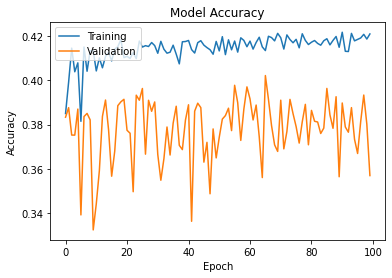

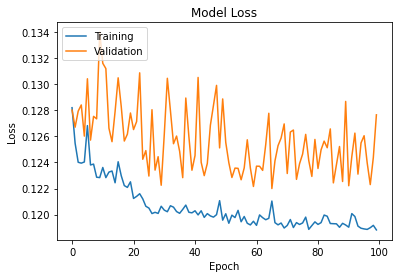

In [ ]:
print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc ='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc ='upper left')
plt.show()

In [7]:
model.save("/content/gdrive/My Drive/CardioNexus/ecgAI/ecg_models/model_input_lead_I_V3")

NameError: ignored

LOAD SAMPLES FROM EDF

In [18]:
def read_edf(filename, output_num_second, output_width):
  f = pyedflib.EdfReader(filename)
  n = f.signals_in_file
  signal_labels = f.getSignalLabels()
  numrecords = f.datarecords_in_file
  info = f.file_info_long() #print(info)
  sigbufs = np.zeros((n, f.getNSamples()[0]))
  sigbufs[0, :] = f.readSignal(0)
  ECGraw= sigbufs[0, :]  
  samplefrequency = f.getSampleFrequency(0)
  fileduration = f.file_duration

  #find pulse packet for start of ecg
  result = np.where(ECGraw == np.amax(ECGraw))
  result = result[0]
  result_length = len(result)
  last_element = result[result_length - 1]
  startpoint = last_element + 3000

  #find end point of ecg
  ecg_length = len(ECGraw)
  endpoint = ecg_length - 4000
  # trim the ecg signal
  ECG = ECGraw[startpoint:endpoint]

  plt.plot(ECG, c='k')
  plt.title('ECG signal')
  plt.show() 
  return ECG, samplefrequency, fileduration, output_num_second, output_width

def create_samples(ECG_signal, samplefrequency, fileduration, output_num_second, output_width):
    freq = samplefrequency
    s = fileduration
    T = 1/freq
    second = T * s
    multi_second = int(output_num_second * second)

    rows = int((len(ECG_signal)/10)/multi_second)
    cols = multi_second
    samples = [[0 for i in range(cols)] for j in range(rows)] 

    i = 0
    for j in range(0, rows):
        for k in range(0, cols):
          samples[j][k] = ECG_signal[i]
          i += 1

    return samples, multi_second

def interpolate_ecg_sample(ECG_signal, output_width, output_num_second, multi_second):
    y = ECG_signal
    x = np.arange(0, len(y))

    x_new = np.arange(0, multi_second-1, (multi_second-1)/output_width)
    y_interp = interp1d(x, y, kind='linear')
    y_new = y_interp(x_new)
    return x_new, y_new

In [76]:
# filename = '15-23-58.EDF'
# ECG_signal, samplefrequency, fileduration, output_num_second, output_width = read_edf(filename, 2, 2000)

samples, multi_second = create_samples(ECG_signal, samplefrequency, fileduration, 2, 2000)

rows = int((len(ECG_signal)/10)/multi_second)
cols = 2000
out_samples = [[0 for i in range(cols)] for j in range(rows)] 

for i in range(0, len(samples)):
    samples_x, samples_y = interpolate_ecg_sample(samples[i], 2000, 2, multi_second)
    out_samples[i] = samples_y

# out = np.expand_dims(out_samples, axis = 0)
out = np.expand_dims(out_samples, axis = 2)
print(out.shape)

(778, 2000, 1)


Load Models for testing:

In [ ]:
# Recreate the exact same model purely from the file:
model_lead_I = keras.models.load_model("/content/gdrive/My Drive/CardioNexus/ecgAI/ecg_models/model_input_lead_I_epoch_120")

In [ ]:
model_lead_II = keras.models.load_model("/content/gdrive/My Drive/CardioNexus/ecgAI/ecg_models/model_input_lead_II_epoch_120")

In [ ]:
model_lead_III = keras.models.load_model("/content/gdrive/My Drive/CardioNexus/ecgAI/ecg_models/model_input_lead_III_epoch_120")

In [8]:
model= keras.models.load_model("/content/gdrive/My Drive/CardioNexus/ecgAI/ecg_models/model_input_lead_I_V3")


In [ ]:
# with tf.compat.v1.Session() as sess:
#     saver = tf.compat.v1.train.import_meta_graph('/content/gdrive/My Drive/CardioNexus/ecgAI/models/model.ckpt-6200.meta')
#     saver = tf.compat.v1.train.Saver(save_relative_paths=True)
#     saver.restore(sess, tf.train.latest_checkpoint('/content/gdrive/My Drive/CardioNexus/ecgAI/models'))

#     # saver.restore(sess, '/content/gdrive/My Drive/CardioNexus/ecgAI/models/model.ckpt-6200.index)
#     # Load weights
#     # saver.restore(sess, tf.train.latest_checkpoint('/content/gdrive/My Drive/CardioNexus/ecgAI/models/'))
tf.compat.v1.reset_default_graph()
imported_meta = tf.compat.v1.train.import_meta_graph("/content/gdrive/My Drive/CardioNexus/ecgAI/models/model.ckpt-6200.meta")

with tf.compat.v1.Session() as sess:
    print(sess)
    # imported_meta.restore(sess, tf.compat.v1.train.latest_checkpoint('./'))
    # h_est2 = sess.run('hor_estimate:0')
    # v_est2 = sess.run('ver_estimate:0')
    # print("h_est: %.2f, v_est: %.2f" % (h_est2, v_est2))


Evalutate model

In [9]:
print(y_test.shape)
print(x_test.shape)

(3, 1, 2000, 6)
(3, 1, 2000, 1)


In [10]:
# model = model_lead_I
test_scores = model.evaluate(x_test, y_test, verbose=2)
print("Test loss:", test_scores[0])
print("Test accuracy:", test_scores[1])

1/1 - 0s - loss: 0.1378 - accuracy: 0.2358
Test loss: 0.13781830668449402
Test accuracy: 0.2358333319425583


Generate prediction using model

In [80]:
# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for EDF samples")
predict_samples = out[:3]
predict_samples = np.expand_dims(predict_samples, axis = 1)
predictions = model.predict(predict_samples)
print("predictions shape:", predictions.shape)
print(predictions[1])

b_file = open("/content/gdrive/My Drive/CardioNexus/ecgAI/outputs/edf_0.txt", "w")
for row in predict_samples[0]:
    np.savetxt(b_file, row)
b_file.close()

b_file = open("/content/gdrive/My Drive/CardioNexus/ecgAI/outputs/edf_1.txt", "w")
for row in predict_samples[1]:
    np.savetxt(b_file, row)
b_file.close()

b_file = open("/content/gdrive/My Drive/CardioNexus/ecgAI/outputs/edf_2.txt", "w")
for row in predict_samples[2]:
    np.savetxt(b_file, row)
b_file.close()

a_file = open("/content/gdrive/My Drive/CardioNexus/ecgAI/outputs/model_input_lead_I_V3_prededf0.csv", "w")
for row in predictions[0]:
    np.savetxt(a_file, row, delimiter=",")
a_file.close()

a_file = open("/content/gdrive/My Drive/CardioNexus/ecgAI/outputs/model_input_lead_I_V3_prededf1.csv", "w")
for row in predictions[1]:
    np.savetxt(a_file, row, delimiter=",")
a_file.close()

a_file = open("/content/gdrive/My Drive/CardioNexus/ecgAI/outputs/model_input_lead_I_V3_prededf2.csv", "w")
for row in predictions[2]:
    np.savetxt(a_file, row, delimiter=",")
a_file.close()

Generate predictions for EDF samples
predictions shape: (3, 1, 2000, 6)
[[[0.0857476  0.13358793 0.07106659 0.17122987 0.18202098 0.35164106]
  [0.08594558 0.1335424  0.06991634 0.17031002 0.1811485  0.35460573]
  [0.08614694 0.1334977  0.06872726 0.1693629  0.18024702 0.3576731 ]
  ...
  [0.08411128 0.13425544 0.07618797 0.17611566 0.18610609 0.3391199 ]
  [0.08416326 0.13424233 0.07604229 0.17597516 0.18598358 0.3394615 ]
  [0.08421406 0.13422798 0.07590418 0.17583987 0.18586732 0.33978474]]]


In [82]:
num = 1
data = predict_samples[num]
classification = predictions[num]
# print(len(classification[1]))
print(classification.shape)

# print(classification[0])
p = []
pr = []
qrs = []
st = []
t = []
tp = []
for sample_idx in range(0, 2000): #iterate through the index of samples
  for class_val in range(0,6): #iterate through each classification
    pred_val = classification[0][sample_idx][class_val]
    if (pred_val) > 0.3 : #set value for minimum probability, sort values into arrays
      if (class_val == 0):
        p.append(sample_idx)
      elif (class_val == 1):
        pr.append(sample_idx)
      elif (class_val == 2):
        qrs.append(sample_idx)
      elif (class_val == 3):
        st.append(sample_idx)
      elif (class_val == 4):
        t.append(sample_idx)
      elif (class_val == 5):
        tp.append(sample_idx)

print(p)
print(len(p))
# print(qrs)

(1, 2000, 6)
[414, 442, 443, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 1019, 1020, 1049, 1182, 1183, 1184, 1185, 1186, 1187, 1188, 1189, 1190, 1191, 1192, 1193, 1194, 1195, 1196, 1197, 1198, 1199, 1200, 1201, 1202, 1203, 1204, 1205, 1206, 1207, 1208, 1209, 1210, 1211, 1212, 1213, 1214, 1215, 1216, 1217, 1218, 1219, 1220, 1221, 1222, 1223, 1224, 1225, 1226, 1227, 1228, 1229, 1230, 1231, 1232, 1233, 1234, 1235, 1236, 1237, 1238, 1239, 1240, 1241, 1242, 1243, 1244, 1245, 1246, 1247, 1248, 1249, 1250, 1251, 1252, 1659, 1688, 1827, 1828, 1829, 1830, 1831, 1832, 1833, 1834, 1835, 1836, 1837, 1838, 1839, 1840, 1841, 1842, 1843, 1844, 1845, 1846, 1847, 1848, 1849, 1850, 1851, 1852, 1853, 1854, 1855, 1

In [83]:
def create_class_dictionary(array, buffersize=50):
  """ create a dictionay for the class. 
      params: array - array of predicted samples
              buffersize - number of samples between each period
      return: dictionary - Each key holds a chunk of the ECG strip corresponding to identified wave
  """
  dictionary = {}
  chunkarr = []
  numchunk = 0
  for k in range(0, len(array)):
      sample_idx = array[k]
      if k < len(array) - 1:
          next_sample_idx = array[k+1]
      else:
          next_sample_idx = sample_idx + buffersize
      
      if sample_idx + buffersize > next_sample_idx: # set minimum boundary between class occurences
          chunkarr.append(sample_idx)
      else:
          chunkarr.append(sample_idx)
          dictionary[numchunk] = chunkarr
          numchunk += 1
          chunkarr = []
      
      
  return dictionary

In [84]:
p_dict = create_class_dictionary(p, buffersize=50)
pr_dict = create_class_dictionary(pr, buffersize=50)
qrs_dict = create_class_dictionary(qrs, buffersize=50)
st_dict = create_class_dictionary(st, buffersize=50)
t_dict = create_class_dictionary(t, buffersize=50)
tp_dict = create_class_dictionary(tp, buffersize=50)
print(p_dict)
print(pr_dict)
print(qrs_dict)
print(st_dict)
print(t_dict)
print(tp_dict)

{0: [414, 442, 443], 1: [579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646], 2: [1019, 1020, 1049], 3: [1182, 1183, 1184, 1185, 1186, 1187, 1188, 1189, 1190, 1191, 1192, 1193, 1194, 1195, 1196, 1197, 1198, 1199, 1200, 1201, 1202, 1203, 1204, 1205, 1206, 1207, 1208, 1209, 1210, 1211, 1212, 1213, 1214, 1215, 1216, 1217, 1218, 1219, 1220, 1221, 1222, 1223, 1224, 1225, 1226, 1227, 1228, 1229, 1230, 1231, 1232, 1233, 1234, 1235, 1236, 1237, 1238, 1239, 1240, 1241, 1242, 1243, 1244, 1245, 1246, 1247, 1248, 1249, 1250, 1251, 1252], 4: [1659, 1688], 5: [1827, 1828, 1829, 1830, 1831, 1832, 1833, 1834, 1835, 1836, 1837, 1838, 1839, 1840, 1841, 1842, 1843, 1844, 1845, 1846, 1847, 1848, 1849, 1850, 1851, 1852, 185

In [85]:
def create_inputs(dictionary, input_size=100):
  """ create a input sample from the first val of each dictionary value
      params: dictionary - dictionary of class predictions, 
              input_size - size of input ()
      return: input - array, each row is 100 samples of the data identified from the start of classification
  """
  rows, cols = (len(dictionary),input_size)
  input = [[0 for i in range(cols)] for j in range(rows)] 
  sample_num = [[0 for i in range(cols)] for j in range(rows)] 
  buff = int(input_size/2)
  for key in dictionary:
      if len(dictionary[key]) > 0:
        startval = dictionary[key][0]
        if (startval + input_size) > len(data[0]):
            dif = len(data[0]) - startval
            dif2 = input_size - dif
            k = 0
            for i in range(dif - input_size, (input_size - dif2)):  
                val = int(data[0][startval + i]) 
                input[key][k] = val
                sample_num[key][k] = startval + i
                k += 1
        else:
          for j in range(-25, 75):
            val = int(data[0][startval + j]) #data[0] = x_test_0
            input[key][j+25] = val
          for j in range(0, input_size):
            sample_num[key][j] = startval + j


  ## need to track the sample number from data
  return input, sample_num

In [86]:
p_inputs, p_sample_nums = create_inputs(p_dict, 100)
pr_inputs, pr_sample_nums = create_inputs(pr_dict, 100)
qrs_inputs, qrs_sample_nums = create_inputs(qrs_dict, 100)
st_inputs, st_sample_nums = create_inputs(st_dict, 100)
t_inputs, t_sample_nums = create_inputs(t_dict, 100)
tp_inputs, tp_sample_nums = create_inputs(tp_dict, 100)

# print(p_sample_nums)

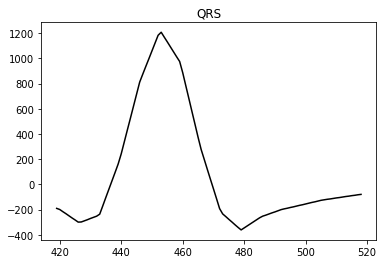

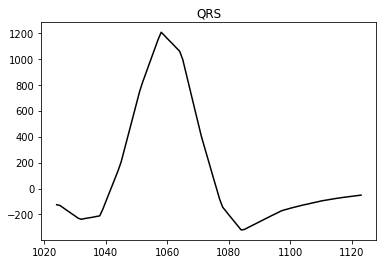

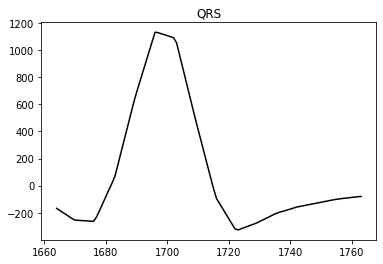

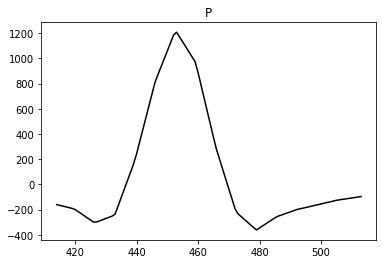

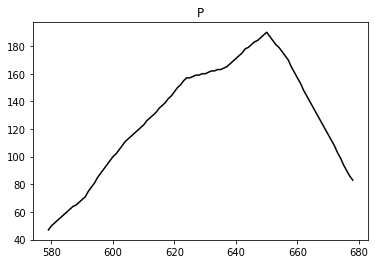

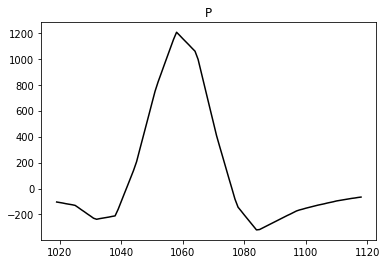

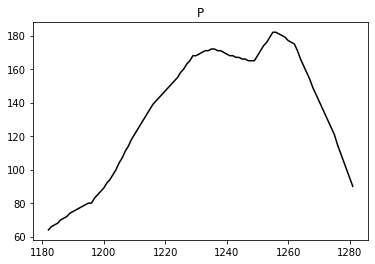

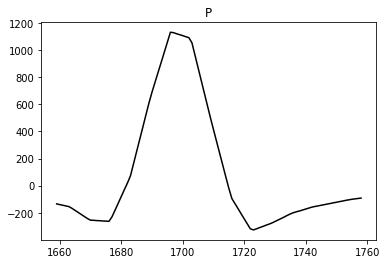

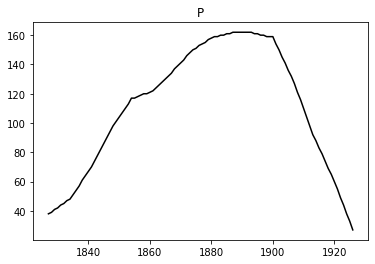

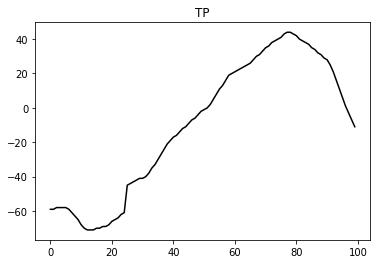

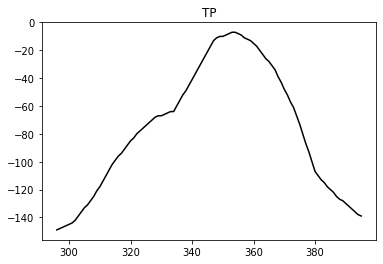

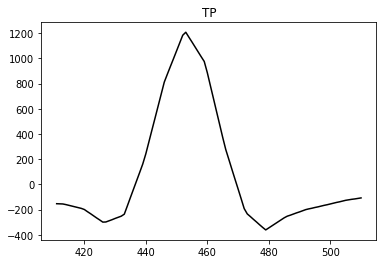

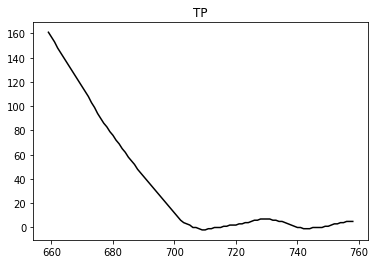

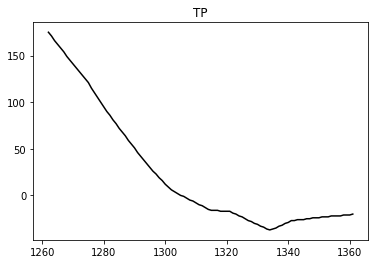

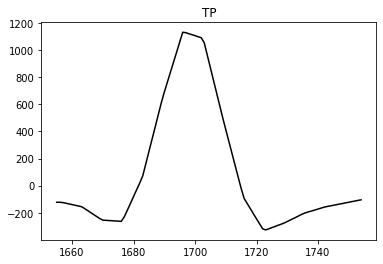

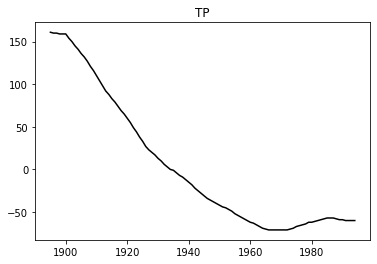

In [87]:
for i in range(0, len(qrs_inputs)):
  plt.plot(qrs_sample_nums[i], qrs_inputs[i], c='k')
  plt.title('QRS')
  plt.show() 

for i in range(0, len(p_inputs)):
  plt.plot(p_sample_nums[i], p_inputs[i], c='k')
  plt.title('P')
  plt.show() 

for i in range(0, len(tp_inputs)):
  plt.plot(tp_sample_nums[i], tp_inputs[i], c='k')
  plt.title('TP')
  plt.show() 

In [ ]:
# train a model on inputs of AF and no-AF, classify as yes/no
# evaluate input sample from trained model
# if classify as AF
# send notification if potential AF for human confirmation
  #notification packet includes 

In [ ]:
# define cnn model - ECGAI Architecture keras.Input(shape=(12,2000,1))
def define_model():
  ## Conv Block 1, output: 2000x12x64
  inputs  = keras.Input(shape=(12,2000,1))
  conv_1_1 = layers.Conv2D(64, (19, 1), activation='relu', kernel_initializer='he_uniform', padding='same') (inputs)
  conv_1_2 = layers.Conv2D(64, (19, 1), activation='relu', kernel_initializer='he_uniform', padding='same') (conv_1_1)
  conv_1_3 = layers.Conv2D(64, (19, 1), activation='relu', kernel_initializer='he_uniform', padding='same') (conv_1_2)

  pool_1 = layers.MaxPooling2D((1, 2)) (conv_1_3)

  # ## Conv Block 2, output: 2000x12x128
  conv_2_1 = layers.Conv2D(128, (19, 1), activation='relu', kernel_initializer='he_uniform', padding='same') (pool_1)
  conv_2_2 = layers.Conv2D(128, (19, 1), activation='relu', kernel_initializer='he_uniform', padding='same') (conv_2_1)
  conv_2_3 = layers.Conv2D(128, (19, 1), activation='relu', kernel_initializer='he_uniform', padding='same') (conv_2_2)
  
  pool_2 = layers.MaxPooling2D((1, 2)) (conv_2_3)

  # ## Conv Block 3, output: 2000x12x256
  conv_3_1 = layers.Conv2D(256, (19, 1), activation='relu', kernel_initializer='he_uniform', padding='same') (pool_2)
  conv_3_2 = layers.Conv2D(256, (19, 1), activation='relu', kernel_initializer='he_uniform', padding='same') (conv_3_1)
  conv_3_3 = layers.Conv2D(256, (19, 1), activation='relu', kernel_initializer='he_uniform', padding='same') (conv_3_2)

  pool_3 = layers.MaxPooling2D((1, 2)) (conv_3_3)

  # ## Conv Block 4, output: 2000x12x512
  conv_4_1 = layers.Conv2D(512, (15, 1), activation='relu', kernel_initializer='he_uniform', padding='same') (pool_3)
  conv_4_2 = layers.Conv2D(512, (15, 1), activation='relu', kernel_initializer='he_uniform', padding='same') (conv_4_1)
  conv_4_3 = layers.Conv2D(512, (15, 1), activation='relu', kernel_initializer='he_uniform', padding='same') (conv_4_2)

  pool_4 = layers.MaxPooling2D((1, 2)) (conv_4_3)

  ## Conv Block 5, output: 2000x12x1024
  conv_5_1 = layers.Conv2D(1024, (15, 1), activation='relu', kernel_initializer='he_uniform', padding='same') (pool_4)
  conv_5_2 = layers.Conv2D(1024, (15, 1), activation='relu', kernel_initializer='he_uniform', padding='same') (conv_5_1)
  conv_5_3 = layers.Conv2D(1024, (15, 1), activation='relu', kernel_initializer='he_uniform', padding='same') (conv_5_2)

  deconv_5 = layers.Conv2DTranspose(512, (8,1), strides=(1,8), activation='relu', kernel_initializer='he_uniform', padding='same') (conv_5_3)
  pool_5 = layers.Concatenate(axis=3)([deconv_5, conv_2_3])

  ## Conv Block 6, output: 2000x12x512
  conv_6_1 = layers.Conv2D(512, (15, 1), activation='relu', kernel_initializer='he_uniform', padding='same') (pool_5)
  conv_6_2 = layers.Conv2D(512, (15, 1), activation='relu', kernel_initializer='he_uniform', padding='same') (conv_6_1)
  conv_6_3 = layers.Conv2D(512, (15, 1), activation='relu', kernel_initializer='he_uniform', padding='same') (conv_6_2)

  deconv_6 = layers.Conv2DTranspose(256, (2,1), strides=(1,2), activation='relu', kernel_initializer='he_uniform', padding='same') (conv_6_3)
  pool_6 = layers.Concatenate(axis=3)([deconv_6, conv_1_3]) 

  ## Conv Block 7, output: 2000x12x256
  conv_7_1 = layers.Conv2D(256, (11,1), activation='relu', kernel_initializer='he_uniform', padding='same') (pool_6)
  conv_7_2 = layers.Conv2D(256, (11,1), activation='relu', kernel_initializer='he_uniform', padding='same') (conv_7_1)
  conv_7_3 = layers.Conv2D(256, (11,1), activation='relu', kernel_initializer='he_uniform', padding='same') (conv_7_2)

  #valid padding conv layer
  conv_8_0 = layers.Conv2D(512, (12,1), activation='relu', kernel_initializer='he_uniform', padding='valid') (conv_7_3)
  
  ## Conv Block 8, output: 2000x12x512
  conv_8_1 = layers.Conv2D(512, (11,1), activation='relu', kernel_initializer='he_uniform', padding='same') (conv_8_0)
  conv_8_2 = layers.Conv2D(512, (11,1), activation='relu', kernel_initializer='he_uniform', padding='same') (conv_8_1)
  conv_8_3 = layers.Conv2D(512, (11,1), activation='relu', kernel_initializer='he_uniform', padding='same') (conv_8_2)

  pool_8 = layers.MaxPooling2D((1,2)) (conv_8_3)
  ## Conv Block 9, output: 2000x12x1024
  conv_9_1 = layers.Conv2D(1024, (11,1), activation='relu', kernel_initializer='he_uniform', padding='same') (pool_8)
  conv_9_2 = layers.Conv2D(1024, (11,1), activation='relu', kernel_initializer='he_uniform', padding='same') (conv_9_1)
  conv_9_3 = layers.Conv2D(1024, (11,1), activation='relu', kernel_initializer='he_uniform', padding='same') (conv_9_2)

  deconv_9 = layers.Conv2DTranspose(512, (2,1), strides=(1,2), activation='relu', kernel_initializer='he_uniform', padding='same') (conv_9_3)
  pool_9 = layers.Concatenate(axis=3)([deconv_9, conv_8_3])
  ## Conv Block 10, output: 2000x12x512
  conv_10_1 = layers.Conv2D(512, (9, 1), activation='relu', kernel_initializer='he_uniform', padding='same') (pool_9)
  conv_10_2 = layers.Dropout(0.5) (conv_10_1)
  conv_10_3 = layers.Conv2D(512, (9, 1), activation='relu', kernel_initializer='he_uniform', padding='same') (conv_10_2)
  conv_10_4 = layers.Dropout(0.5) (conv_10_3)
  conv_10_5 = layers.Conv2D(512, (9, 1), activation='relu', kernel_initializer='he_uniform', padding='same') (conv_10_4)
  conv_10_6 = layers.Dropout(0.5) (conv_10_4)
  
  ## Conv Block 11, output: 2000x1x6
  conv_11 = layers.Conv1D(6, 1) (conv_10_6)
  outputs = conv_11

  model = keras.Model(inputs=inputs, outputs=outputs, name="ecg")
  # compile model
  model.compile(optimizer='adam',loss='mean_squared_error', metrics=['accuracy'])

  return model